In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from collections import OrderedDict
from torch.nn import init
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import time



In [12]:
def conv3x3(in_channels, out_channels, stride=1, 
            padding=1, bias=True, groups=1):    
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)


class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        if self.pooling:
            x = self.pool(x)
        return x

     


class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5, 
                 start_filts=64, img_size = 256):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the 
                first conv.
        """
        super(UNet, self).__init__()

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth
        self.img_size = img_size

        self.down_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            # pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=True)
            self.down_convs.append(down_conv)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.reset_params()
        
        out_channels =self.down_convs[self.depth-1].conv2.out_channels
        out_img_size = self.img_size/(2**(self.depth))
        self.fully_connected_size = int(out_img_size**2 * out_channels)
        fully_connected=nn.Linear(self.fully_connected_size, 2)
        init.normal(fully_connected.weight)
        self.add_module('fully_connected', fully_connected)

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal(m.weight)
            init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)


    def forward(self, x):
        for i, module in enumerate(self.down_convs):
            x = module(x)
            
        x = self.fully_connected(x.view(-1, self.fully_connected_size))
        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        return x



In [13]:
from bisect import bisect_right
from torch.optim import Optimizer

class _LRScheduler(object):
    def __init__(self, optimizer, last_epoch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.step(last_epoch + 1)
        self.last_epoch = last_epoch

    def get_lr(self):
        raise NotImplementedError

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr


class LambdaLR(_LRScheduler):
    """Sets the learning rate of each parameter group to the initial lr
    times a given function. When last_epoch=-1, sets initial lr as lr.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        lr_lambda (function or list): A function which computes a multiplicative
            factor given an integer parameter epoch, or a list of such
            functions, one for each group in optimizer.param_groups.
        last_epoch (int): The index of last epoch. Default: -1.

    Example:
        >>> # Assuming optimizer has two groups.
        >>> lambda1 = lambda epoch: epoch // 30
        >>> lambda2 = lambda epoch: 0.95 ** epoch
        >>> scheduler = LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
        >>> for epoch in range(100):
        >>>     scheduler.step()
        >>>     train(...)
        >>>     validate(...)
    """
    def __init__(self, optimizer, lr_lambda, last_epoch=-1):
        self.optimizer = optimizer
        if not isinstance(lr_lambda, list) and not isinstance(lr_lambda, tuple):
            self.lr_lambdas = [lr_lambda] * len(optimizer.param_groups)
        else:
            if len(lr_lambda) != len(optimizer.param_groups):
                raise ValueError("Expected {} lr_lambdas, but got {}".format(
                    len(optimizer.param_groups), len(lr_lambda)))
            self.lr_lambdas = list(lr_lambda)
        self.last_epoch = last_epoch
        super(LambdaLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * lmbda(self.last_epoch)
                for lmbda, base_lr in zip(self.lr_lambdas, self.base_lrs)]



class StepLR(_LRScheduler):
    """Sets the learning rate of each parameter group to the initial lr
    decayed by gamma every step_size epochs. When last_epoch=-1, sets
    initial lr as lr.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        step_size (int): Period of learning rate decay.
        gamma (float): Multiplicative factor of learning rate decay.
            Default: 0.1.
        last_epoch (int): The index of last epoch. Default: -1.

    Example:
        >>> # Assuming optimizer uses lr = 0.5 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 60
        >>> # lr = 0.0005   if 60 <= epoch < 90
        >>> # ...
        >>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
        >>> for epoch in range(100):
        >>>     scheduler.step()
        >>>     train(...)
        >>>     validate(...)
    """

    def __init__(self, optimizer, step_size, gamma=0.1, last_epoch=-1):
        self.step_size = step_size
        self.gamma = gamma
        super(StepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.gamma ** (self.last_epoch // self.step_size)
                for base_lr in self.base_lrs]



class MultiStepLR(_LRScheduler):
    """Set the learning rate of each parameter group to the initial lr decayed
    by gamma once the number of epoch reaches one of the milestones. When
    last_epoch=-1, sets initial lr as lr.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        milestones (list): List of epoch indices. Must be increasing.
        gamma (float): Multiplicative factor of learning rate decay.
            Default: 0.1.
        last_epoch (int): The index of last epoch. Default: -1.

    Example:
        >>> # Assuming optimizer uses lr = 0.5 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 80
        >>> # lr = 0.0005   if epoch >= 80
        >>> scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
        >>> for epoch in range(100):
        >>>     scheduler.step()
        >>>     train(...)
        >>>     validate(...)
    """

    def __init__(self, optimizer, milestones, gamma=0.1, last_epoch=-1):
        if not list(milestones) == sorted(milestones):
            raise ValueError('Milestones should be a list of'
                             ' increasing integers. Got {}', milestones)
        self.milestones = milestones
        self.gamma = gamma
        super(MultiStepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.gamma ** bisect_right(self.milestones, self.last_epoch)
                for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Set the learning rate of each parameter group to the initial lr decayed
    by gamma every epoch. When last_epoch=-1, sets initial lr as lr.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        gamma (float): Multiplicative factor of learning rate decay.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, gamma, last_epoch=-1):
        self.gamma = gamma
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.gamma ** self.last_epoch
                for base_lr in self.base_lrs]


class ReduceLROnPlateau(object):
    """Reduce learning rate when a metric has stopped improving.
    Models often benefit from reducing the learning rate by a factor
    of 2-10 once learning stagnates. This scheduler reads a metrics
    quantity and if no improvement is seen for a 'patience' number
    of epochs, the learning rate is reduced.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        mode (str): One of `min`, `max`. In `min` mode, lr will
            be reduced when the quantity monitored has stopped
            decreasing; in `max` mode it will be reduced when the
            quantity monitored has stopped increasing. Default: 'min'.
        factor (float): Factor by which the learning rate will be
            reduced. new_lr = lr * factor. Default: 0.1.
        patience (int): Number of epochs with no improvement after
            which learning rate will be reduced. Default: 10.
        verbose (bool): If ``True``, prints a message to stdout for
            each update. Default: ``False``.
        threshold (float): Threshold for measuring the new optimum,
            to only focus on significant changes. Default: 1e-4.
        threshold_mode (str): One of `rel`, `abs`. In `rel` mode,
            dynamic_threshold = best * ( 1 + threshold ) in 'max'
            mode or best * ( 1 - threshold ) in `min` mode.
            In `abs` mode, dynamic_threshold = best + threshold in
            `max` mode or best - threshold in `min` mode. Default: 'rel'.
        cooldown (int): Number of epochs to wait before resuming
            normal operation after lr has been reduced. Default: 0.
        min_lr (float or list): A scalar or a list of scalars. A
            lower bound on the learning rate of all param groups
            or each group respectively. Default: 0.
        eps (float): Minimal decay applied to lr. If the difference
            between new and old lr is smaller than eps, the update is
            ignored. Default: 1e-8.

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = ReduceLROnPlateau(optimizer, 'min')
        >>> for epoch in range(10):
        >>>     train(...)
        >>>     val_loss = validate(...)
        >>>     # Note that step should be called after validate()
        >>>     scheduler.step(val_loss)
    """

    def __init__(self, optimizer, mode='min', factor=0.1, patience=10,
                 verbose=False, threshold=1e-4, threshold_mode='rel',
                 cooldown=0, min_lr=0, eps=1e-8):

        if factor >= 1.0:
            raise ValueError('Factor should be < 1.0.')
        self.factor = factor

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(min_lr, list) or isinstance(min_lr, tuple):
            if len(min_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} min_lrs, got {}".format(
                    len(optimizer.param_groups), len(min_lr)))
            self.min_lrs = list(min_lr)
        else:
            self.min_lrs = [min_lr] * len(optimizer.param_groups)

        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown
        self.cooldown_counter = 0
        self.mode = mode
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.best = None
        self.num_bad_epochs = None
        self.mode_worse = None  # the worse value for the chosen mode
        self.is_better = None
        self.eps = eps
        self.last_epoch = -1
        self._init_is_better(mode=mode, threshold=threshold,
                             threshold_mode=threshold_mode)
        self._reset()

    def _reset(self):
        """Resets num_bad_epochs counter and cooldown counter."""
        self.best = self.mode_worse
        self.cooldown_counter = 0
        self.num_bad_epochs = 0

    def step(self, metrics, epoch=None):
        current = metrics
        if epoch is None:
            epoch = self.last_epoch = self.last_epoch + 1
        self.last_epoch = epoch

        if self.is_better(current, self.best):
            self.best = current
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        if self.in_cooldown:
            self.cooldown_counter -= 1
            self.num_bad_epochs = 0  # ignore any bad epochs in cooldown

        if self.num_bad_epochs > self.patience:
            self._reduce_lr(epoch)
            self.cooldown_counter = self.cooldown
            self.num_bad_epochs = 0

    def _reduce_lr(self, epoch):
        for i, param_group in enumerate(self.optimizer.param_groups):
            old_lr = float(param_group['lr'])
            new_lr = max(old_lr * self.factor, self.min_lrs[i])
            if old_lr - new_lr > self.eps:
                param_group['lr'] = new_lr
                if self.verbose:
                    print('Epoch {:5d}: reducing learning rate'
                          ' of group {} to {:.4e}.'.format(epoch, i, new_lr))

    @property
    def in_cooldown(self):
        return self.cooldown_counter > 0

    def _init_is_better(self, mode, threshold, threshold_mode):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if threshold_mode not in {'rel', 'abs'}:
            raise ValueError('threshold mode ' + mode + ' is unknown!')
        if mode == 'min' and threshold_mode == 'rel':
            rel_epsilon = 1. - threshold
            self.is_better = lambda a, best: a < best * rel_epsilon
            self.mode_worse = float('Inf')
        elif mode == 'min' and threshold_mode == 'abs':
            self.is_better = lambda a, best: a < best - threshold
            self.mode_worse = float('Inf')
        elif mode == 'max' and threshold_mode == 'rel':
            rel_epsilon = threshold + 1.
            self.is_better = lambda a, best: a > best * rel_epsilon
            self.mode_worse = -float('Inf')
        else:  # mode == 'max' and epsilon_mode == 'abs':
            self.is_better = lambda a, best: a > best + threshold
            self.mode_worse = -float('Inf')



In [14]:
use_gpu = torch.cuda.is_available()
print("GPU available: {}".format(use_gpu))

GPU available: True


In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(128),
        transforms.RandomSizedCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
    ]),
    'val': transforms.Compose([
        transforms.Scale(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [31]:
plt.ion()

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, num_workers=4, shuffle=True) for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

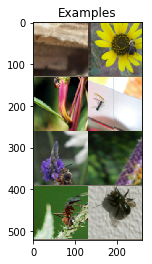

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get some training data
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs, nrow = 2)

imshow(out, 'Examples')

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True) # Set model to traning mode
            else:
                model.train(False) # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                    
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data,1)
                # print("Outputs\n{}".format(outputs))
                # print("Labels\n{}".format(labels))
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # loas best weights
    model.load_state_dict(best_model_wts)
    return model

In [38]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[np.asscalar(preds.cpu().numpy()[j])]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return        
            

In [39]:
# if __name__ == "__main__":
    
model = UNet(3, depth=5, start_filts = 16, img_size=128)
# x = Variable(torch.FloatTensor(np.random.random((1, 3, img_size, img_size))))
# y = model(x)
# print(y)


if use_gpu:
    model = model.cuda()


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.3)

In [41]:
model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=30)


Epoch 0/29
----------
train Loss: 0.2096 Acc: 0.4877
val Loss: 0.2123 Acc: 0.4575

Epoch 1/29
----------
train Loss: 0.1981 Acc: 0.4631
val Loss: 0.2064 Acc: 0.5425

Epoch 2/29
----------
train Loss: 0.1863 Acc: 0.4918
val Loss: 0.1761 Acc: 0.5098

Epoch 3/29
----------
train Loss: 0.1936 Acc: 0.4877
val Loss: 0.2353 Acc: 0.4575

Epoch 4/29
----------
train Loss: 0.1722 Acc: 0.6148
val Loss: 0.1778 Acc: 0.5425

Epoch 5/29
----------
train Loss: 0.1715 Acc: 0.5861
val Loss: 0.1661 Acc: 0.5556

Epoch 6/29
----------
train Loss: 0.1749 Acc: 0.5738
val Loss: 0.1667 Acc: 0.5621

Epoch 7/29
----------
train Loss: 0.1630 Acc: 0.6475
val Loss: 0.1636 Acc: 0.6144

Epoch 8/29
----------
train Loss: 0.1597 Acc: 0.6393
val Loss: 0.1582 Acc: 0.6340

Epoch 9/29
----------
train Loss: 0.1621 Acc: 0.6189
val Loss: 0.1652 Acc: 0.6013

Epoch 10/29
----------
train Loss: 0.1527 Acc: 0.6762
val Loss: 0.1585 Acc: 0.6144

Epoch 11/29
----------
train Loss: 0.1453 Acc: 0.7049
val Loss: 0.1524 Acc: 0.6144

Ep

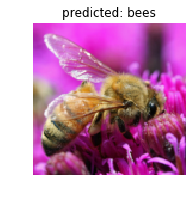

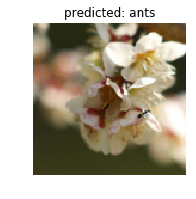

In [50]:
visualize_model(model, 2)

plt.ioff()
plt.show()